<a href="https://colab.research.google.com/github/CalvHobbes/mountain-classifier/blob/main/Resnet_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U neptune

In [2]:
! pip install transformers pip comet_ml datasets evaluate



In [3]:
!git clone https://github.com/CalvHobbes/mountain-classifier.git

fatal: destination path 'mountain-classifier' already exists and is not an empty directory.


In [4]:
import os
from google.colab import userdata
os.environ["WANDB_DISABLED"] = "true"


In [3]:
# import comet_ml
# from comet_ml import Experiment
# from comet_ml import start
# from comet_ml.integration.pytorch import log_model
# from google.colab import userdata
# import os

# experiment = start(
#   api_key="tv9OhbrvWqXeyrnIlTKVBUkwQ",
#   project_name="mountain-classifier",
#   workspace="calvhobbes"
# )

# comet_key = userdata.get("COMET_API_KEY")
# comet_ml.login(project_name="mountain-classifier", api_key=comet_key)

# os.environ["COMET_LOG_ASSETS"] = "True"
# os.environ["COMET_API_KEY"] = comet_key


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/calvhobbes/mountain-classifier/b0b22d99c0d4423682bae68af0f12f5c

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [5]:
import neptune
neptune_key = userdata.get("NEPTUNE_API_TOKEN")
neptune_project='priya.marwaha/mountain-classifier'
os.environ["NEPTUNE_API_TOKEN"] = neptune_key
os.environ["NEPTUNE_PROJECT"] = neptune_project
run = neptune.init_run(
    api_token=neptune_key,
    project=neptune_project,
)



[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/priya.marwaha/mountain-classifier/e/MOUNTAIN-2


In [6]:
from transformers.integrations import NeptuneCallback
neptune_callback = NeptuneCallback(
    run=run,
    log_checkpoints='best',  # Update to "last" or "best" if you want to log model checkpoints to Neptune
)

In [7]:
from PIL import Image
import numpy as np
import torch

def preprocess_image(image):
    image = Image.open(image["image"]).convert("RGB")
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = image.transpose(2, 0, 1)  # Convert to (C, H, W) format
    image = torch.tensor(image)
    return image

In [8]:
# from datasets import load_dataset

# # Load dataset from directory structure (like `train` and `test` folders)
# # This assumes your `train_dir` and `test_dir` folders have subfolders per class
# train_dir = "mountain-classifier/data/train"
# test_dir = "mountain-classifier/data/test"

# # Load the training and test datasets
# train_dataset = load_dataset("imagefolder", data_dir=train_dir)
# test_dataset = load_dataset("imagefolder", data_dir=test_dir)


from datasets import load_dataset

# Define the root folder path
root_path = "mountain-classifier/14Summits.v1i.dataset"
train_dir = f"{root_path}/train"
test_dir = f"{root_path}/test"
valid_dir = f"{root_path}/valid"

# Load train, test, and valid datasets
train_dataset = load_dataset("imagefolder", data_dir=train_dir)
test_dataset = load_dataset("imagefolder", data_dir=test_dir)
valid_dataset = load_dataset("imagefolder", data_dir=valid_dir)

# Example: Inspect the datasets
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)
print("Valid Dataset:", valid_dataset)



Resolving data files:   0%|          | 0/3282 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/155 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/314 [00:00<?, ?it/s]

Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3282
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 155
    })
})
Valid Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 314
    })
})


In [9]:
from transformers import ViTFeatureExtractor,AutoModelForImageClassification, AutoImageProcessor

model_name_or_path = 'microsoft/resnet-50'
feature_extractor = AutoImageProcessor.from_pretrained(model_name_or_path)

feature_extractor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [10]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [8]:
process_example(train_dataset['train'][0])

{'pixel_values': tensor([[[[-1.4672, -1.4672, -1.4672,  ..., -1.6042, -1.6042, -1.6042],
          [-1.4672, -1.4672, -1.4672,  ..., -1.5870, -1.5870, -1.5870],
          [-1.4672, -1.4672, -1.4672,  ..., -1.5699, -1.5699, -1.5699],
          ...,
          [-0.4054, -0.3198, -0.4226,  ..., -1.6384, -1.8268, -1.8953],
          [-0.3712, -0.4226, -0.4226,  ..., -1.5357, -1.8953, -1.9809],
          [-0.4397, -0.4739, -0.4397,  ..., -1.7069, -1.9124, -1.9809]],

         [[-1.3704, -1.3704, -1.3704,  ..., -1.5105, -1.5105, -1.5105],
          [-1.3704, -1.3704, -1.3704,  ..., -1.4930, -1.4930, -1.4930],
          [-1.3704, -1.3704, -1.3704,  ..., -1.4755, -1.4755, -1.4755],
          ...,
          [-0.2850, -0.1975, -0.3025,  ..., -1.5455, -1.7381, -1.8081],
          [-0.2500, -0.3025, -0.3025,  ..., -1.4405, -1.8081, -1.8957],
          [-0.3200, -0.3550, -0.3200,  ..., -1.6155, -1.8256, -1.8957]],

         [[-1.1421, -1.1421, -1.1421,  ..., -1.2816, -1.2816, -1.2816],
          [-1

In [11]:
from PIL import Image
import torchvision.transforms as transforms

def transform(example_batch):
    #
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs



prepared_train_ds = train_dataset.with_transform(transform)
prepared_test_ds = test_dataset.with_transform(transform)
prepared_valid_ds = valid_dataset.with_transform(transform)



In [10]:
prepared_valid_ds['train'][0]["pixel_values"].shape

torch.Size([3, 224, 224])

In [12]:
labels = prepared_train_ds['train'].features['label'].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label


In [13]:
import numpy as np
import evaluate
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [14]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,

)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([14, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments, EarlyStoppingCallback
model_name = model_name_or_path.split("/")[-1]
output_dir=f"{model_name}-finetuned-10122024"
# training_args = TrainingArguments(
#   output_dir="./vit-base-v1-eval-steps",
#   per_device_train_batch_size=16,
#   eval_strategy="steps",
#   num_train_epochs=4,
#   fp16=True,
#   save_steps=100,
#   eval_steps=100,
#   logging_steps=10,
#   learning_rate=2e-4,
#   save_total_limit=2,
#   remove_unused_columns=False,
#   push_to_hub=False,
#   report_to='none',
#   load_best_model_at_end=True,
# )




# args = TrainingArguments(
#     output_dir=output_dir,
#     remove_unused_columns=False,
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=25,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     greater_is_better=True,
#     push_to_hub=False

# )

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    logging_steps=10,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",#['neptune']
    max_grad_norm=1.0,
    lr_scheduler_type="cosine"
)
# experiment.log_parameters(training_args)
# run['training_args'] = training_args



In [16]:
import numpy as np
import evaluate
from transformers import Trainer




# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_train_ds['train'],
    eval_dataset=prepared_valid_ds['train'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
     callbacks=[neptune_callback]
)



<ipython-input-16-d8726d211328>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,2.624400,2.629447,0.114650
2,2.523800,2.567719,0.136943
4,2.441400,2.512020,0.165605
6,2.301500,2.452012,0.216561
8,2.250200,2.410949,0.235669
10,2.206000,2.379813,0.242038
12,2.184500,2.378111,0.257962
14,2.116700,2.358367,0.245223


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 6 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/priya.marwaha/mountain-classifier/e/MOUNTAIN-2/metadata
***** train metrics *****
  epoch                    =     14.8544
  total_flos               = 965414680GF
  train_loss               =      2.3335
  train_runtime            =  0:14:48.56
  train_samples_per_second =      55.404
  train_steps_per_second   =       0.861


In [18]:
log_model(experiment, model=model, model_name=output_dir)

NameError: name 'log_model' is not defined

In [21]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval_validation", metrics)
trainer.save_metrics("eval_validation", metrics)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/priya.marwaha/mountain-classifier/e/MOUNTAIN-2
***** eval_validation metrics *****
  epoch                   =    14.8544
  eval_accuracy           =      0.258
  eval_loss               =     2.3781
  eval_runtime            = 0:00:04.53
  eval_samples_per_second =     69.185
  eval_steps_per_second   =      4.407


In [22]:
metrics = trainer.evaluate(prepared_test_ds['train'])
trainer.log_metrics("eval_test", metrics)
trainer.save_metrics("eval_test", metrics)

***** eval_test metrics *****
  epoch                   =    14.8544
  eval_accuracy           =     0.2645
  eval_loss               =     2.3203
  eval_runtime            = 0:00:02.10
  eval_samples_per_second =     73.586
  eval_steps_per_second   =      4.747


In [ ]:
experiment.end()

In [ ]:
# trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/priyamarwaha/vit-base-v1-eval-epoch-maxgrad-decay-cosine/commit/c9f90e7e9a461802a8fc99ede6934b258b9d2f89', commit_message='End of training', commit_description='', oid='c9f90e7e9a461802a8fc99ede6934b258b9d2f89', pr_url=None, repo_url=RepoUrl('https://huggingface.co/priyamarwaha/vit-base-v1-eval-epoch-maxgrad-decay-cosine', endpoint='https://huggingface.co', repo_type='model', repo_id='priyamarwaha/vit-base-v1-eval-epoch-maxgrad-decay-cosine'), pr_revision=None, pr_num=None)

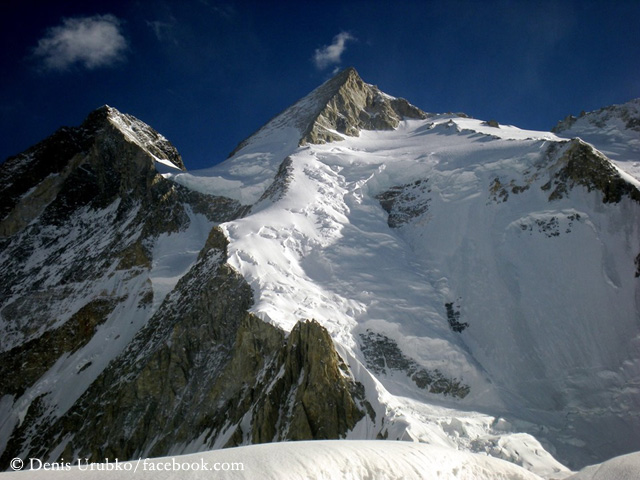

In [23]:
from PIL import Image
import requests

url = 'https://abenteuer-berg.de/wp-content/uploads/2019/08/GAsherbrum-II.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [24]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = 'priyamarwaha/vit-base-v1-eval-epoch-maxgrad-decay-cosine'
local_model_path = training_args.output_dir

image_processor = AutoImageProcessor.from_pretrained(local_model_path) # replace with local path
model = AutoModelForImageClassification.from_pretrained(local_model_path)

In [ ]:
model

In [26]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [27]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [28]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Gasherbrum II


In [30]:
output_dir=f"{model_name}-finetuned-10122024"
output_dir
training_args.output_dir

'resnet-50-finetuned-10122024'